Predicting user churn based on transaction data and listening history. Steps include:

1. Clean and normalize data for analysis

2. Exploratory Analysis/Feature Engineering

3. Preprocessing/Model building and Evaluation

Note: Criteria of "churn" is no new valid service subscription within 30 days after current membership expires. Transaction data after April 2017 is purposely omitted by the poster. The dataset can be found on https://www.kaggle.com/competitions/kkbox-churn-prediction-challenge/data

# Step 1: Clean and normalize data for analysis

In [1]:
import pandas as pd
import datetime
import numpy as np
pd.set_option('display.max_columns', 500)

In [11]:
traindf = pd.read_csv('train_v2.csv')
transdf = pd.read_csv('transactions_v2.csv', parse_dates = ['transaction_date','membership_expire_date'])
userdf = pd.read_csv(r"C:\Users\marsh\Desktop\Springboard\Capstone2\user_logs_v2.csv", parse_dates = ['date'])
memdf = pd.read_csv('members_v3.csv', parse_dates = ['registration_init_time'])

In [12]:
# merge train and transaction tables, remove null values

df = traindf.merge(transdf, on = 'msno', how = 'left')
df = df.sort_values(['msno','transaction_date'])
df.dropna(inplace= True)
df.isna().sum()
df.dtypes

msno                              object
is_churn                           int64
payment_method_id                float64
payment_plan_days                float64
plan_list_price                  float64
actual_amount_paid               float64
is_auto_renew                    float64
transaction_date          datetime64[ns]
membership_expire_date    datetime64[ns]
is_cancel                        float64
dtype: object

In [18]:
# Let's deal with duplicate user id entries first. Here I aggregate transactions
# with the average time between transactions and membership duration with the 
# sum.

dup = df[df.msno.duplicated()].reset_index()
dup = df[df.msno.isin(dup.msno)]
dup['prev_user'] = dup.msno.shift(1)
dup.iloc[0,10] = '+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw='
dup['avg_time_between_transactions'] = (dup.transaction_date -
                              dup.transaction_date.shift(1)).where(dup.prev_user == dup.msno, 0)
dup.iloc[0,11] = 0
dup['sum_membership_duration'] = dup.membership_expire_date - dup.transaction_date
dup.sum_membership_duration = pd.to_timedelta(dup.sum_membership_duration, unit='d')
dup.sum_membership_duration = dup.sum_membership_duration.dt.days
dup.loc[dup.sum_membership_duration < 0] = 0
dup.avg_time_between_transactions = pd.to_timedelta(dup.avg_time_between_transactions, unit='d')
dup.avg_time_between_transactions = dup.avg_time_between_transactions.dt.days
dup.loc[dup.avg_time_between_transactions< 0] = 0

C:\Users\marsh\AppData\Local\Temp/ipykernel_19020/660429278.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dup['prev_user'] = dup.msno.shift(1)
C:\Users\marsh\AppData\Local\Temp/ipykernel_19020/660429278.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dup['avg_time_between_transactions'] = (dup.transaction_date -
C:\Users\marsh\AppData\Local\Temp/ipykernel_19020/660429278.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [20]:
# Aggregate remaining columns with the mode or max where it is appropriate.

dup = dup.groupby('msno', as_index = False).agg({'is_churn': lambda x:x.value_counts().index[0],'payment_method_id': lambda x:x.value_counts().index[0], 'payment_plan_days': 'max', 'plan_list_price': 'max',
                                       'actual_amount_paid': 'max', 'is_auto_renew': lambda x:x.value_counts().index[0], 'transaction_date': 'max', 'membership_expire_date': 'max',
                                       'is_cancel': lambda x:x.value_counts().index[0], 'sum_membership_duration': 'sum', 'avg_time_between_transactions': 'mean'})
dup = dup.rename(columns = {'transaction_date': 'latest_transaction', 'membership_expire_date': 'latest_membership_expiration'})
dup.drop(index=dup.index[0], 
        axis=0, 
        inplace=True)

In [22]:
# Create same columns for non-duplicate user id entries, and aggregate remaining
# columns.
nondup = df[~df.msno.isin(dup.msno)]
nondup.sort_values('transaction_date')
nondup['sum_membership_duration'] = nondup.membership_expire_date - nondup.transaction_date
nondup['avg_time_between_transactions'] = 0
nondup.sum_membership_duration = pd.to_timedelta(nondup.sum_membership_duration, unit='d')
nondup.sum_membership_duration = nondup.sum_membership_duration.dt.days
nondup.loc[nondup.sum_membership_duration < 0, 'sum_membership_duration'] = 0
nondup = nondup.groupby('msno', as_index = False).agg({'is_churn': lambda x:x.value_counts().index[0],'payment_method_id': lambda x:x.value_counts().index[0], 'payment_plan_days': 'max', 'plan_list_price': 'max',
                                       'actual_amount_paid': 'max', 'is_auto_renew': lambda x:x.value_counts().index[0], 'transaction_date': 'max', 'membership_expire_date': 'max',
                                       'is_cancel': lambda x:x.value_counts().index[0], 'sum_membership_duration': 'sum', 'avg_time_between_transactions': 'mean'})
nondup = nondup.rename(columns = {'transaction_date': 'latest_transaction', 'membership_expire_date': 'latest_membership_expiration'})


C:\Users\marsh\AppData\Local\Temp/ipykernel_19020/4138481773.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nondup['sum_membership_duration'] = nondup.membership_expire_date - nondup.transaction_date
C:\Users\marsh\AppData\Local\Temp/ipykernel_19020/4138481773.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nondup['avg_time_between_transactions'] = 0
C:\Users\marsh\AppData\Local\Temp/ipykernel_19020/4138481773.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [23]:
df = pd.concat([dup,nondup], ignore_index = True)
df.msno.duplicated().any()

False

In [24]:
# Aggregate user table by sum of songs listened to and the latest listen date.
# Then further calculation on listening history. For example, percent_25 
# indicates how many songs they listen to until only 25% of the song is completed.

userdf = userdf.groupby('msno', as_index = False).agg({'date': 'max', 'num_25': 'sum', 'num_50': 'sum', 'num_75': 'sum',
                                 'num_985': 'sum', 'num_100': 'sum', 'num_unq': 'max', 'total_secs': 'sum'})
userdf['percent_25'] = userdf['num_25']/(userdf['num_25']+userdf['num_50']+userdf['num_75']+userdf['num_985']+userdf['num_100'])
userdf['percent_50'] = userdf['num_50']/(userdf['num_25']+userdf['num_50']+userdf['num_75']+userdf['num_985']+userdf['num_100'])
userdf['percent_100'] = (userdf['num_985']+userdf['num_100'])/(userdf['num_25']+userdf['num_50']+userdf['num_75']+userdf['num_985']+userdf['num_100'])
userdf = userdf.drop(columns = ['num_25', 'num_50', 'num_75', 'num_985', 'num_100'])

In [25]:
# merge user table with previous table and remove null values
df1 = df.merge(userdf, how = 'left')
df1 = df1.dropna()
df1 = df1.rename(columns = {'date' : 'latest_listen_date'})
df1.isnull().sum()

msno                             0
is_churn                         0
payment_method_id                0
payment_plan_days                0
plan_list_price                  0
actual_amount_paid               0
is_auto_renew                    0
latest_transaction               0
latest_membership_expiration     0
is_cancel                        0
sum_membership_duration          0
avg_time_between_transactions    0
latest_listen_date               0
num_unq                          0
total_secs                       0
percent_25                       0
percent_50                       0
percent_100                      0
dtype: int64

In [26]:
# merge member table with previous table, and drop gender column since over 50% 
# of it contains null values.
memdf = pd.read_csv('members_v3.csv', parse_dates = ['registration_init_time'])
df1 = df1.merge(memdf, on = 'msno',how = 'left')
df1.drop(columns = ['bd','gender'], inplace = True)
df1 = df1.dropna()
df1.to_csv('Usertables.csv',index = False)

# Step 2. Exploratory Data Analysis

In [10]:
import matplotlib.pyplot as plt
import matplotlib.axes
import seaborn as sns
from scipy.stats import pointbiserialr, pearsonr, chi2_contingency

In [3]:
df = pd.read_csv('Usertables.csv', parse_dates = ['latest_transaction','latest_membership_expiration','latest_listen_date','registration_init_time'])

46603 0.06421604967191294


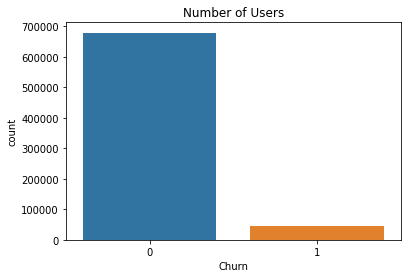

In [24]:
# I will look at each feature to see if there is any visible relationship with
# user churn.

totusers = len(df)
sns.countplot(x = 'is_churn', data = df)
plt.title('Number of Users')
plt.xlabel('Churn')
print(len(df[df.is_churn == 1]), df.is_churn.mean())


# Total of 6% of users appeared to have churned.

In [16]:
df[['is_churn', "sum_membership_duration"]].groupby("is_churn").agg({"sum_membership_duration":['mean', 'count','sum']})


# Total membership duration is highly correlated with user churn. 

sum_membership_duration                  
                            mean   count       sum
is_churn                                          
0                      94.090395  679119  63898575
1                     272.285840   46603  12689337

<AxesSubplot: title={'center': 'Churn vs Total Membership Duration'}, xlabel='is_churn', ylabel='sum_membership_duration'>

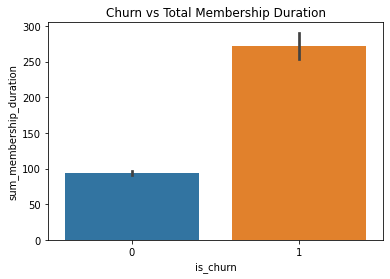

In [6]:
plt.title('Churn vs Total Membership Duration')
plt.ylabel('Total membership duration (average)')
sns.barplot(x = df.is_churn, y= df.sum_membership_duration)

# After plotting it, users with longer memberships seem more likely to churn.

[Text(0, 0, '0-30.708 days'),
 Text(1, 0, '30.709-31.377 days'),
 Text(2, 0, '31.378-31.982 days'),
 Text(3, 0, '>31.982 days')]

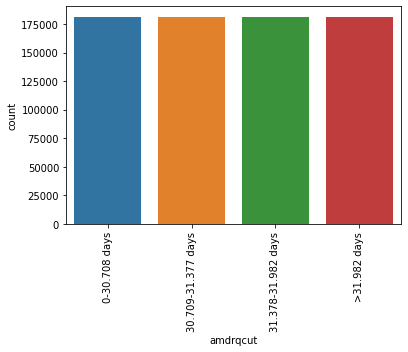

In [61]:
# Here, I use the pandas qcut function to see time interval is associated with
# user churn.

df['amdrqcut'] = df['sum_membership_duration'].apply(lambda x: x + np.random.random())
df['amdrqcut'] = pd.qcut(x= df["amdrqcut"], q = 4,duplicates = 'drop')

x = sns.countplot(x = 'amdrqcut', data = df)
x.set_xticklabels(labels = ['0-30.708 days','30.709-31.377 days','31.378-31.982 days','>31.982 days'],rotation = 90)

([<matplotlib.axis.XTick at 0x2b5042dce20>,
 [Text(0.0, 0, '0- 30.74 days'),
  Text(1.0, 0, '30.75 - 31.39 days'),
  Text(2.0, 0, '31.4 - 32.05 days'),
  Text(3.0, 0, '> 32.05 days')])

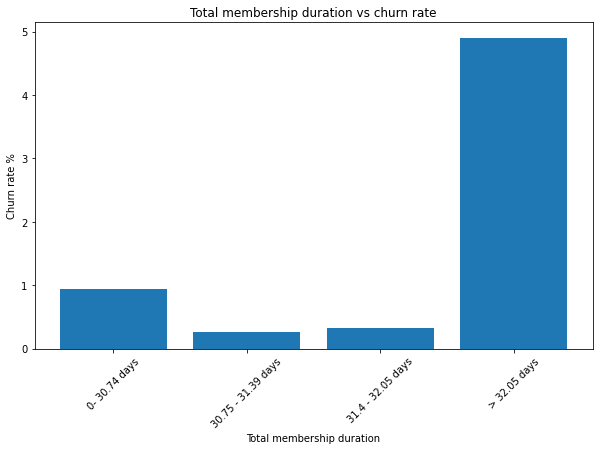

In [102]:
df['amdrqcut'] = df.amdrqcut.astype(str)
amdrqcut = df.groupby('amdrqcut').sum()['is_churn'] /totusers *100

plt.figure(figsize = (10,6))
plt.title('Total membership duration vs churn rate')
x = plt.bar(amdrqcut.index, amdrqcut.values)
plt.xlabel('Total membership duration')
plt.ylabel('Churn rate %')
plt.xticks(ticks = amdrqcut.index, rotation= 45, labels = ['0- 30.74 days', '30.75 - 31.39 days', '31.4 - 32.05 days', '> 32.05 days'])

# Users that have memberships longer than 32 days are very likely to churn.

Text(0, 0.5, 'Average time between transactions (days)')

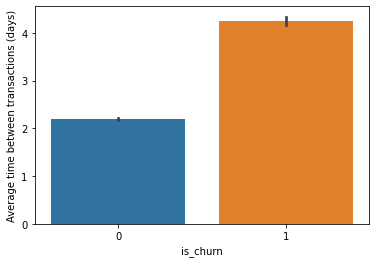

In [7]:
# Let's take a look at average time between transactions.

sns.barplot(x = df.is_churn, y = df.avg_time_between_transactions)
plt.ylabel('Average time between transactions (days)')

# On average, users that churned had 4 days between transactions, while non-churned only had two.

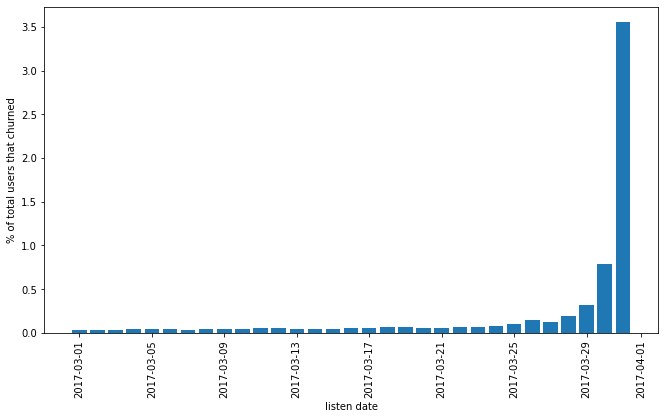

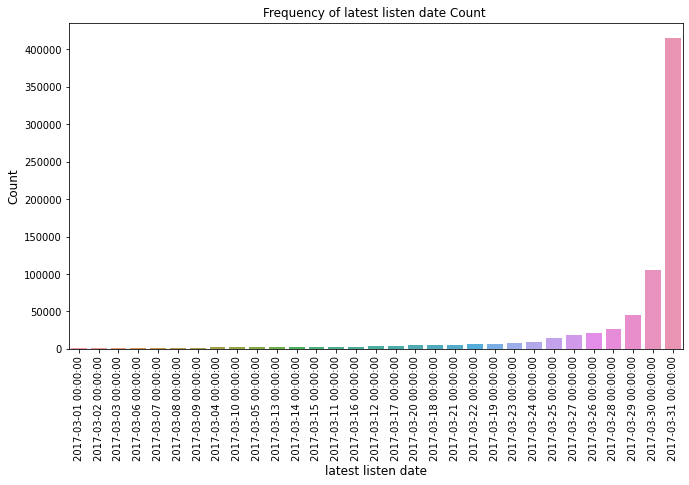

In [24]:
# Then we look at latest listen date. 

listen = df.groupby('latest_listen_date').sum()['is_churn'] / totusers *100

plt.figure(figsize=(11,6))
plt.bar(listen.index, listen.values)
plt.xlabel('listen date')
plt.ylabel('% of total users that churned')
plt.xticks(rotation= 'vertical')


plt.figure(figsize=(11,6))
sns.countplot(x="latest_listen_date", data=df, order = df.latest_listen_date.value_counts().index[::-1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('latest listen date', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of latest listen date Count ", fontsize=12)
plt.show()

# Though it appears that many users churned in March, there are also far more 
# entries with a listen date in late March. Therefore, there isn't an obvious
# conclusion that can be drawn here.

(0.0, 250.0)

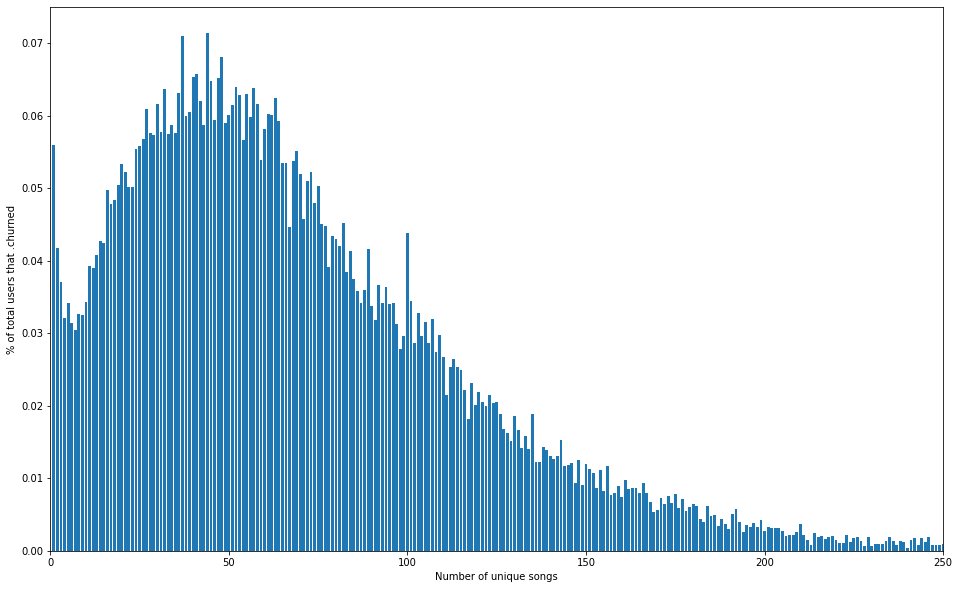

In [39]:
# Next, we look at the number of unique songs each user has listened to.

unq = df.groupby('num_unq').sum()['is_churn']
unq = unq / totusers * 100
plt.figure(figsize = (16,10))
plt.bar(list(unq.index), list(unq))
plt.xlabel('Number of unique songs')
plt.ylabel('% of total users that .churned')
plt.xlim([0,250])

# There's a spike in churned users that only listen to around 40-50 unique songs.

Text(0, 0.5, 'Average number of unique songs')

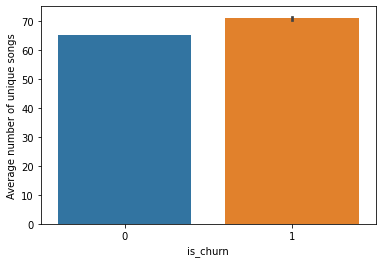

In [23]:
sns.barplot(x = df.is_churn, y = df.num_unq)
plt.ylabel('Average number of unique songs')

# On average, churned users listen to 5 more unique songs that non-churned users do.

Text(0.5, 1.0, 'Average seconds listened vs churn rate')

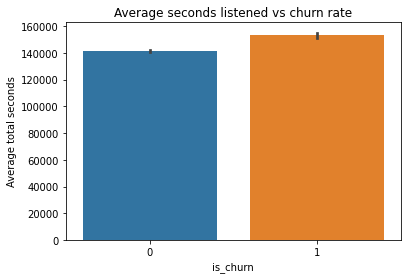

In [6]:
# Next, we look at the total secs listened for each group.

sns.barplot(x = df.is_churn, y = df.total_secs)
plt.ylabel("Average total seconds")
plt.title('Average seconds listened vs churn rate')
# Again, we see that churned users listen to songs a little longer than non-churned users do.

Text(0.5, 1.0, 'Autorenewal vs churn rate')

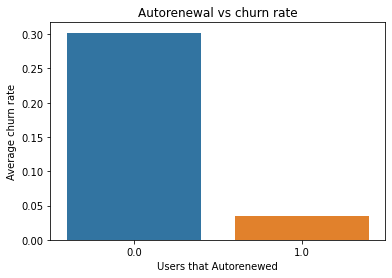

In [24]:
# Next, we will look at autorenewal against churn rate.

autorenewmean = df.groupby('is_auto_renew').mean()['is_churn']
sns.barplot(x = autorenewmean.index, y = autorenewmean.values)
plt.xlabel('Users that Autorenewed')
plt.ylabel('Average churn rate')
plt.xticks(ticks = [0,1])
plt.title('Autorenewal vs churn rate')

# On average, we see a 25% difference in churn rate for users who do not choose auto-renewal.

In [26]:

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cramers_v(df.is_churn,df.is_auto_renew)

0.3458796050746641

([<matplotlib.axis.XTick at 0x1f1422c10a0>,
 [Text(0, 0, '0.0'), Text(1, 0, '1.0')])

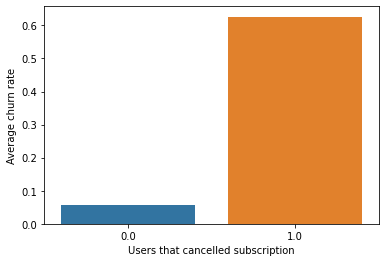

In [26]:
# Next, we'll look at users that actively canceled their subscription.

cancel = df.groupby('is_cancel').mean()['is_churn']
sns.barplot(x = cancel.index, y = cancel.values)
plt.xlabel('Users that cancelled subscription')
plt.ylabel('Average churn rate')
plt.xticks(ticks = [0,1])

# We see over 50% difference in churn rate for users who actively cancelled their subscription, which isn't too surprising.

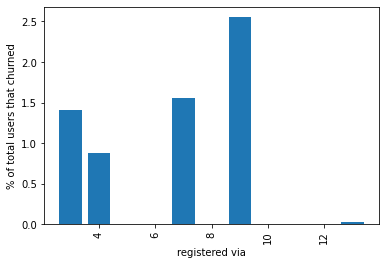

In [16]:
# Next, we'll look at registration method.

reg = df.groupby('registered_via').sum()['is_churn'] / totusers *100

plt.bar(reg.index, reg.values)
plt.xlabel('registered via')
plt.ylabel('% of total users that churned')
plt.xticks(rotation= 'vertical')
plt.show()

# Those who registered with methods 7 and 9 appeared to have churned more often
# than users who registered via other methods.

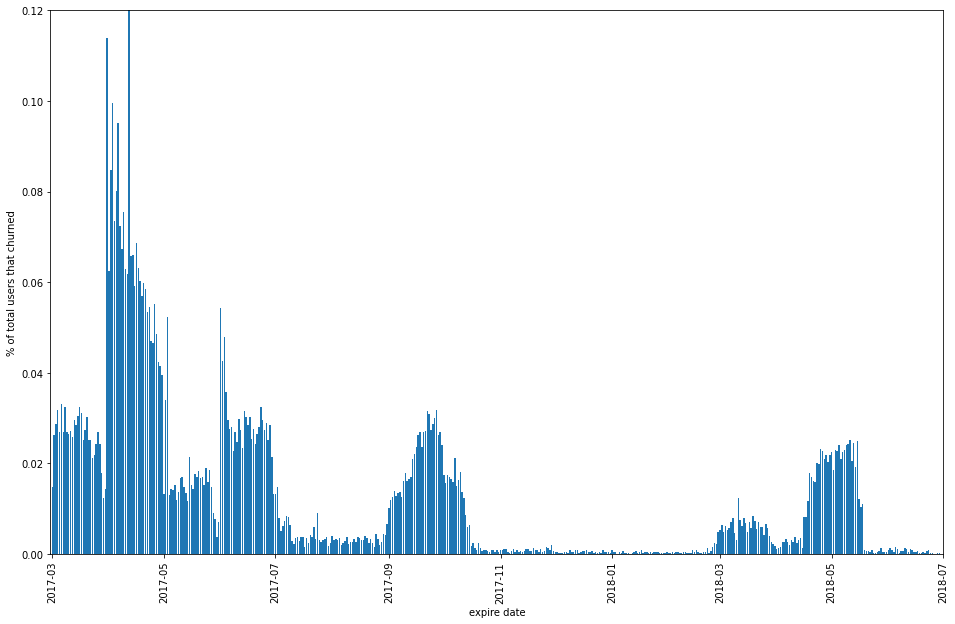

In [45]:
# Next, we'll look at latest membership expiration.

expire = df.groupby('latest_membership_expiration').sum()['is_churn'] / totusers *100
plt.figure(figsize = (16,10))
plt.bar(expire.index, expire.values)
plt.xlabel('expire date')
plt.ylabel('% of total users that churned')
plt.xticks(rotation= 'vertical')
plt.xlim([datetime.date(2017, 2, 28), datetime.date(2018, 7,1)])
plt.ylim([0,0.12])
plt.show()

# We see a large spike in user churn when membership expiration date falls in 
# the April timeframe. This may be due to there being more entries for April users.

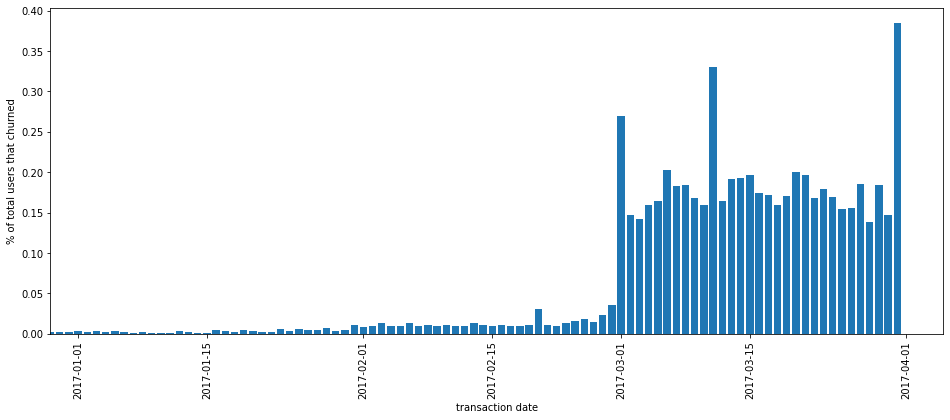

In [50]:
# Next, transaction data.

transaction = df.groupby('latest_transaction').sum()['is_churn'] / totusers *100
plt.figure(figsize = (16,6))
plt.bar(transaction.index, transaction.values)
plt.xlabel('transaction date')
plt.ylabel('Churn rate %')
plt.xticks(rotation= 'vertical')
plt.xlim([datetime.date(2016, 12, 29), datetime.date(2017, 4,5)])
plt.show()

# Again, there is a large spike in user churn in March. This may be due to
# there being more transaction entries in March. This also aligns with
# our April expiration date spike since most users choose monthly subscription 
# plans.

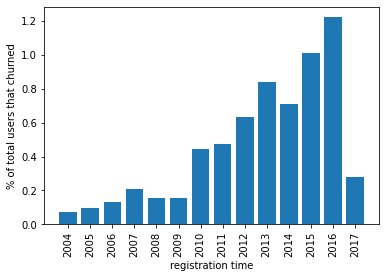

In [51]:
# Next, we'll look at registration date by year.

df['year'] = pd.to_datetime(df['registration_init_time']).dt.to_period('Y')
df['year'] = df.year.astype(str)
regtime = df.groupby('year').sum()['is_churn'] / totusers *100
plt.bar(regtime.index, regtime.values)
plt.xlabel('registration time')
plt.ylabel('Churn rate %')
plt.xticks(rotation= 'vertical')
plt.show()

# The data shows a high spike in user churn leading up to 2017.

[Text(0, 0, '0-99.799 NTD'),
 Text(1, 0, '99.80-149.242 NTD'),
 Text(2, 0, '149.243-149.764 NTD'),
 Text(3, 0, '>149.765 NTD')]

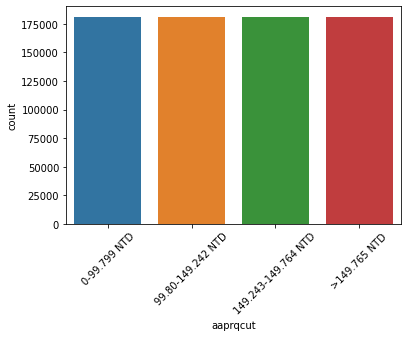

In [92]:
# Next, I'll use the qcut function again to see if there is any correlation between
# actual amount paid and user churn, which is highly likely.
df['actual_amount_rand'] = df['actual_amount_paid'].apply(lambda x: x + np.random.random())
df['aaprqcut'] = pd.qcut(x= df["actual_amount_rand"], q = 4,duplicates = 'drop')
x = sns.countplot(x = 'aaprqcut', data = df)
x.set_xticklabels(labels = ['0-99.799 NTD','99.80-149.242 NTD','149.243-149.764 NTD','>149.765 NTD'],rotation = 45)

([<matplotlib.axis.XTick at 0x2b504de4fd0>,
 [Text(0.0, 0, '0-99.799 NTD'),
  Text(1.0, 0, '99.80-149.242 NTD'),
  Text(2.0, 0, '149.243-149.764 NTD'),
  Text(3.0, 0, '>149.765 NTD')])

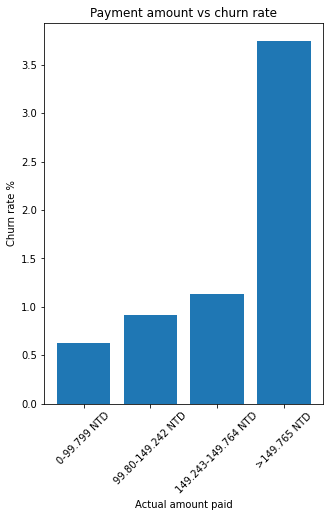

In [109]:
df['aaprqcut'] = df.aaprqcut.astype(str)
aaprqcut = df.groupby('aaprqcut').sum()['is_churn'] /totusers *100

plt.figure(figsize = (5,7))
plt.title('Payment amount vs churn rate')
x = plt.bar(aaprqcut.sort_values().index, aaprqcut.sort_values().values)
plt.xlabel('Actual amount paid')
plt.ylabel('Churn rate %')
plt.xticks(ticks = aaprqcut.sort_values().index,rotation= 45, labels = ['0-99.799 NTD','99.80-149.242 NTD','149.243-149.764 NTD','>149.765 NTD'])
# Users that pay more are more likely to churn. This aligns with our previous
# analysis of total membership duration. In other words, longer memberships =
# higher amount paid = higher churn rate

Text(0, 0.5, 'Average amount paid (NTD)')

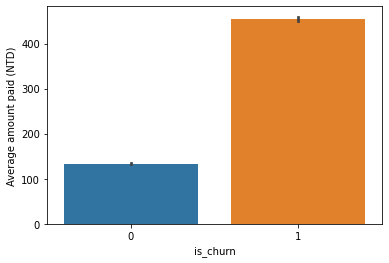

In [27]:
sns.barplot(x = df.is_churn,y = df.actual_amount_paid)
plt.ylabel('Average amount paid (NTD)')

# On average, users that churned paid 300 NTD more (equivalent to $10) than non-churned users.

In [29]:
df[['is_churn', "actual_amount_paid"]].groupby("is_churn").agg({"actual_amount_paid":['mean', 'count','sum']})

actual_amount_paid                    
                       mean   count         sum
is_churn                                       
0                133.911027  679119  90941523.0
1                454.858056   46603  21197750.0

<AxesSubplot: title={'center': 'Distribution of Actual Amount Paid'}, xlabel='Actual Amount paid', ylabel='Frequency'>

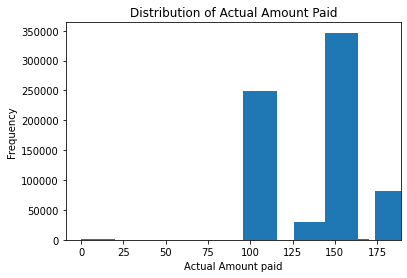

In [32]:
# Plotting the histogram of actual amount paid shows that those who pay more than
# 150 Taiwan dollars make up less than 25% of our dataset.

plt.title('Distribution of Actual Amount Paid')
plt.xlabel('Actual Amount paid')
df.loc[df['actual_amount_paid'] < 250, 'actual_amount_paid'].plot.hist(bins = 30, width = 20)

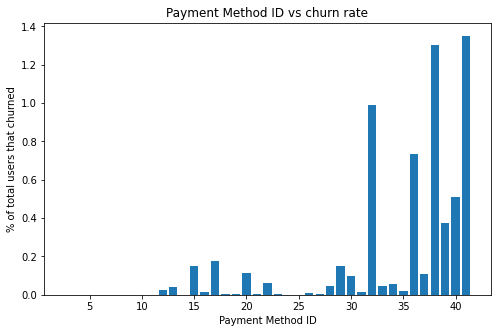

0.5158157975169558

In [28]:
# Next, we'll look at payment method id.

plt.figure(figsize = (8,5))
pmi = df.groupby('payment_method_id').sum()['is_churn'] / totusers * 100
plt.bar(list(pmi.index), list(pmi))
plt.title('Payment Method ID vs churn rate')
plt.xlabel('Payment Method ID')
plt.ylabel('% of total users that churned')
plt.show()

# Users who pay via method 38 and 41 churn far more often than users who 
# pay using other methods.


[Text(0.5, 0, 'Payment plan days'), Text(0, 0.5, 'count')]

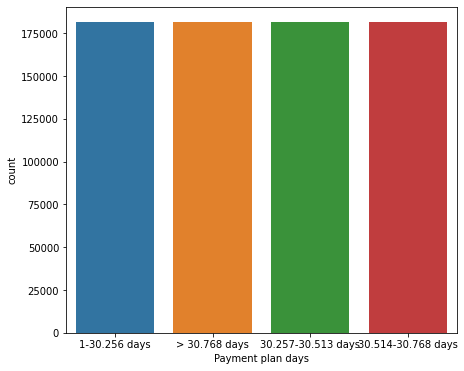

In [94]:
# Next, we'll look at payment plan days. I will utilize the qcut function again.

df['ppdrqcut'] = df['payment_plan_days'].apply(lambda x: x + np.random.random())

df['ppdrqcut'] = pd.qcut(x= df["ppdrqcut"], q = 4,duplicates = 'drop', labels = ['1-30.256 days','30.257-30.513 days'
                                                                                , '30.514-30.768 days','> 30.768 days'])
df['ppdrqcut'] = df.ppdrqcut.astype(str)
plt.figure(figsize=(7,6))
plt.xlabel('payment plan days')
ax = sns.countplot(x = 'ppdrqcut', data = df)
ax.set(xlabel = 'Payment plan days', ylabel = 'count')

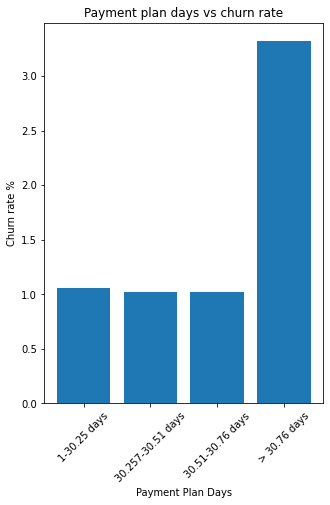

In [110]:
plt.figure(figsize = (5,7))
plt.title('Payment plan days vs churn rate')
ppd = df.groupby('ppdrqcut').sum()['is_churn'] /totusers *100
plt.bar(ppd.index, ppd.values)
plt.xlabel('Payment Plan Days')
plt.ylabel('Churn rate %')
plt.xticks(ticks = ppd.index, rotation= 45, labels = ['1-30.25 days','30.257-30.51 days', '30.51-30.76 days','> 30.76 days'])
plt.show()

# Users that opt for payment plans longer than 30 days are more likely to churn,
# which is to be expected. There's a trend showing that to users who opt for
# longer memberships are more likley to churn than users who choose have shorter
# memberships.

<AxesSubplot: xlabel='is_churn', ylabel='payment_plan_days'>

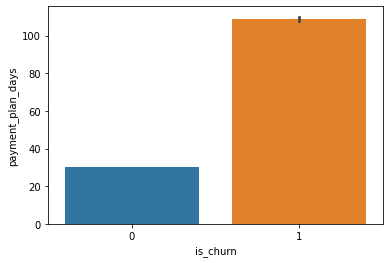

In [28]:
sns.barplot( x = df.is_churn, y = df.payment_plan_days)

# On average, churned users chose longer payment plans (about 70 days longer) than non-churned users.

In [112]:
df[['is_churn', "payment_plan_days"]].groupby("is_churn").agg({"payment_plan_days":['mean', 'count','sum']})

payment_plan_days                    
                      mean   count         sum
is_churn                                      
0                 30.08453  679119  20430976.0
1                108.83044   46603   5071825.0

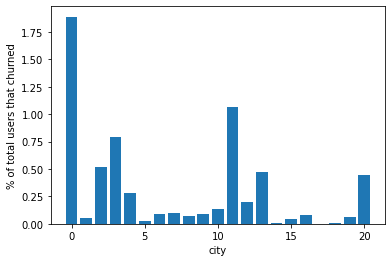

In [60]:
# Next, we'll look at cities.

city = df.groupby('city').sum()['is_churn'] / totusers * 100
plt.bar(np.arange(len(list(city.index))), list(city))
plt.xlabel('city')
plt.ylabel('% of total users that churned')
plt.show()

# Users in city 0 (the exact city is unknown to us) are more likely to churn.

<AxesSubplot: >

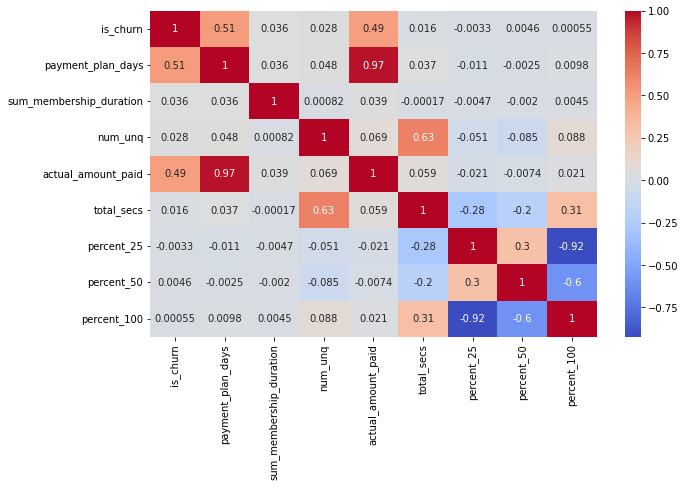

In [40]:
# For good measure, let's take a look at the heatmap and regression coefficients to see if there is any
# other correlations we may be missing.

plt.figure(figsize = (10,6))
num = df[['is_churn','payment_plan_days','sum_membership_duration','num_unq','actual_amount_paid','total_secs','percent_25','percent_50','percent_100']]
num
sns.heatmap(num.corr(),cmap = 'coolwarm', annot = True)

In [ ]:
df['latest_transaction_year'] = df['latest_transaction'].dt.year
df['latest_transaction_month'] = df['latest_transaction'].dt.month
df['latest_transaction_week'] = df['latest_transaction'].dt.week
df['latest_transaction_day'] = df['latest_transaction'].dt.day

df['latest_membership_expiration_year'] = df['latest_membership_expiration'].dt.year
df['latest_membership_expiration_month'] = df['latest_membership_expiration'].dt.month
df['latest_membership_expiration_week'] = df['latest_membership_expiration'].dt.week
df['latest_membership_expiration_day'] = df['latest_membership_expiration'].dt.day

df['latest_listen_date_year'] = df['latest_listen_date'].dt.year
df['latest_listen_date_month'] = df['latest_listen_date'].dt.month
df['latest_listen_date_week'] = df['latest_listen_date'].dt.week
df['latest_listen_date_day'] = df['latest_listen_date'].dt.day

df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_week'] = df['registration_init_time'].dt.week
df['registration_init_time_day'] = df['registration_init_time'].dt.day

df = df.drop(columns = ['latest_transaction','latest_membership_expiration','latest_listen_date','registration_init_time'])

In [5]:
# Using GLM to determine correlation coefficients as well as p-value for all our
# features. We will ignore date coefficients for this analysis.


import statsmodels.api as sm
import statsmodels.formula.api as smf

df.columns

glm_columns = 'payment_method_id'
for column in df.columns:
    if column not in ['is_churn','msno','payment_method_id']:
        glm_columns = glm_columns + ' + ' + column
    
glm_model = smf.glm(formula = 'is_churn ~ {}'.format(glm_columns), data = df, family = sm.families.Binomial())
res = glm_model.fit()
res.summary()

# There's a lot to take in here. The features that stand out and can most 
# effectively reduce churn are ones with extremely small P-values and negative
# coefficients. 

# Notable ones are is_auto_renew, payment_method_id, actual_amount_paid, and registration method.

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               is_churn   No. Observations:               725722
Model:                            GLM   Df Residuals:                   725692
Model Family:                Binomial   Df Model:                           29
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -90351.
Date:                Fri, 03 Feb 2023   Deviance:                   1.8004e+05
Time:                        17:04:19   Pearson chi2:                 3.31e+16
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.0087      0.000     34.234      0.000       0.008       0.009
payment_method_id                     -0.0290      0.002    -15.851      0.000      -0.033      -0.025
payment_plan_days                      0.0160      0.001     21.505      0.000       0.015       0.017
plan_list_price                        0.0324      0.001     58.049      0.000       0.031       0.034
actual_amount_paid                    -0.0322      0.001    -60.469      0.000      -0.033      -0.031
is_auto_renew                         -1.8383      0.019    -95.122      0.000      -1.876      -1.800
is_cancel                              4.7514      0.028    167.004      0.000       4.696       4.807
sum_membership_duration               -0.0012   2.05e-05    -59.101      0.000      -0.001      -0.001
avg_time_between_transactions          0.0123      0.000     27.727      0.000       0.011       0.013
num_unq                                0.0015      0.000      8.877      0.000       0.001       0.002
total_secs                         -1.622e-07   4.84e-08     -3.350      0.001   -2.57e-07   -6.73e-08
percent_25                            -0.1698      0.172     -0.989      0.323      -0.506       0.167
percent_50                            -0.1235      0.216     -0.571      0.568      -0.548       0.301
percent_100                            0.1430      0.162      0.881      0.378      -0.175       0.461
city                                   0.0130      0.001     11.843      0.000       0.011       0.015
registered_via                        -0.0479      0.003    -14.194      0.000      -0.055      -0.041
latest_transaction_year              -29.7752      0.477    -62.373      0.000     -30.711     -28.840
latest_transaction_month              -4.3277      0.116    -37.280      0.000      -4.555      -4.100
latest_transaction_week                0.3207      0.026     12.144      0.000       0.269       0.372
latest_transaction_day                -0.0993      0.004    -25.949      0.000      -0.107      -0.092
latest_membership_expiration_year     12.2250      0.213     57.300      0.000      11.807      12.643
latest_membership_expiration_month     1.1083      0.105     10.565      0.000       0.903       1.314
latest_membership_expiration_week      0.0802      0.024      3.368      0.001       0.034       0.127
latest_membership_expiration_day       0.0034      0.003      0.963      0.336      -0.003       0.010
latest_listen_date_year               17.5955      0.514     34.234      0.000      16.588      18.603
latest_listen_date_month               0.0262      0.001     34.234      0.000       0.025       0.028
latest_listen_date_week                0.2098      0.036      5.902      0.000       0.140      

In [97]:
# I'll do a sanity check using point-biserial from scipy and Cramer's v function for cat-to-cat associations.

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


numerical = df[['sum_membership_duration','num_unq', 'total_secs','actual_amount_paid','payment_plan_days','avg_time_between_transactions']]
cat = df[['is_auto_renew','is_cancel','registered_via','payment_method_id']]

coeffs = []
for column in numerical:
    coeffs.append([column, pointbiserialr(df.is_churn,df[column])[0]])

for column in cat:
    coeffs.append([column, cramers_v(df[column], df.is_churn)])
    
corr_coeff = pd.DataFrame(data = coeffs, columns = ['Feature','CC']).sort_values('CC', ascending = False)
corr_coeff

,Feature,CC
9,payment_method_id,0.515816
4,payment_plan_days,0.506000
3,actual_amount_paid,0.492414
6,is_auto_renew,0.345880
7,is_cancel,0.254632
8,registered_via,0.156701
5,avg_time_between_transactions,0.049787
0,sum_membership_duration,0.035820
1,num_unq,0.027861
2,total_secs,0.015547


Conclusions: We see a couple of interesting trends here. Users that have churned this month appear to have far longer memberships than those who didn't. In other words, users that opted for payment plans greater than 30 days were more likely to churn. Those who also chose to auto-renew their plan rather than manually renewing it were less likely to churn. Registration method and listening history also seem to correlate with churn rate to a lesser degree.

Therefore, we target users who have longer memberships and manually renew their memberships.

# Step 3: Preprocessing/Model building

In [8]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, fbeta_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

In [4]:
df = pd.read_csv('Usertables.csv', parse_dates = ['latest_transaction','latest_membership_expiration','latest_listen_date','registration_init_time'])
# Process dates for our model.

df['latest_transaction_year'] = df['latest_transaction'].dt.year
df['latest_transaction_month'] = df['latest_transaction'].dt.month
df['latest_transaction_week'] = df['latest_transaction'].dt.week
df['latest_transaction_day'] = df['latest_transaction'].dt.day

df['latest_membership_expiration_year'] = df['latest_membership_expiration'].dt.year
df['latest_membership_expiration_month'] = df['latest_membership_expiration'].dt.month
df['latest_membership_expiration_week'] = df['latest_membership_expiration'].dt.week
df['latest_membership_expiration_day'] = df['latest_membership_expiration'].dt.day

df['latest_listen_date_year'] = df['latest_listen_date'].dt.year
df['latest_listen_date_month'] = df['latest_listen_date'].dt.month
df['latest_listen_date_week'] = df['latest_listen_date'].dt.week
df['latest_listen_date_day'] = df['latest_listen_date'].dt.day

df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_week'] = df['registration_init_time'].dt.week
df['registration_init_time_day'] = df['registration_init_time'].dt.day

df = df.drop(columns = ['latest_transaction','latest_membership_expiration','latest_listen_date','registration_init_time'])

C:\Users\marsh\AppData\Local\Temp/ipykernel_16044/3790750258.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['latest_transaction_week'] = df['latest_transaction'].dt.week
C:\Users\marsh\AppData\Local\Temp/ipykernel_16044/3790750258.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['latest_membership_expiration_week'] = df['latest_membership_expiration'].dt.week
C:\Users\marsh\AppData\Local\Temp/ipykernel_16044/3790750258.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['latest_listen_date_week'] = df['latest_listen_date'].dt.week
C:\Users\marsh\AppData\Local\Temp/ipykernel_16044/3790750258.py:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df

In [10]:
# Divide our train and test data, then scale/transform using a Standard Scaler.
X = df.drop(columns = ['is_churn','msno'])
y = df['is_churn']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)
scaler = StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [73]:
# I'll test the performance of three models: A Random Forest, Logistic 
# Regression, and Extreme Gradient Boost. Let's try the Random Forest first.
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, random_state = 42,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)

In [75]:
# Use cross-validation to determine the best hyperparameters.

#max_depth = [6,10,20]
#n_estimators = [10,50,100]
#max_features = ['auto','sqrt']
#max_depth,n_estimators

#rfc_pipe = Pipeline(
#steps = [('standardscaler', StandardScaler()),
#('classifier', RandomForestClassifier())])


#grid_params = {'standardscaler': [StandardScaler(),None],
#               'classifier__n_estimators' : n_estimators,
#               'classifier__max_depth': max_depth,
#              'classifier__max_features': max_features
#}

#rfc_grid_cv = RandomizedSearchCV(rfc_pipe, param_distributions = grid_params, cv = StratifiedKFold(5), n_jobs = -1, scoring = 'f1')
#model = rfc_grid_cv.fit(X_train,y_train)
#model.best_params_

{'standardscaler': StandardScaler(),
 'classifier__n_estimators': 100,
 'classifier__max_features': 'auto',
 'classifier__max_depth': 20}

In [118]:
# Let's fit our data using these parameters and print the classification report.
# The best metric to determine performance will be F1 score since we want to 
# focus on true positive labels.

tune_rfc = RandomForestClassifier(n_estimators=100, max_features = 'auto', max_depth = 20, random_state = 42,n_jobs=-1)

    
tune_rfc = tune_rfc.fit(X_train_scaled, y_train)
cm = confusion_matrix(y_test, y_pred)

y_pred_test = tune_rfc.predict(X_test_scaled)
y_pred_train = tune_rfc.predict(X_train_scaled)
print(classification_report(y_train, y_pred_train)), print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    509339
           1       1.00      0.88      0.94     34952

    accuracy                           0.99    544291
   macro avg       0.99      0.94      0.97    544291
weighted avg       0.99      0.99      0.99    544291

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    169780
           1       0.94      0.84      0.89     11651

    accuracy                           0.99    181431
   macro avg       0.96      0.92      0.94    181431
weighted avg       0.99      0.99      0.99    181431



(None, None)

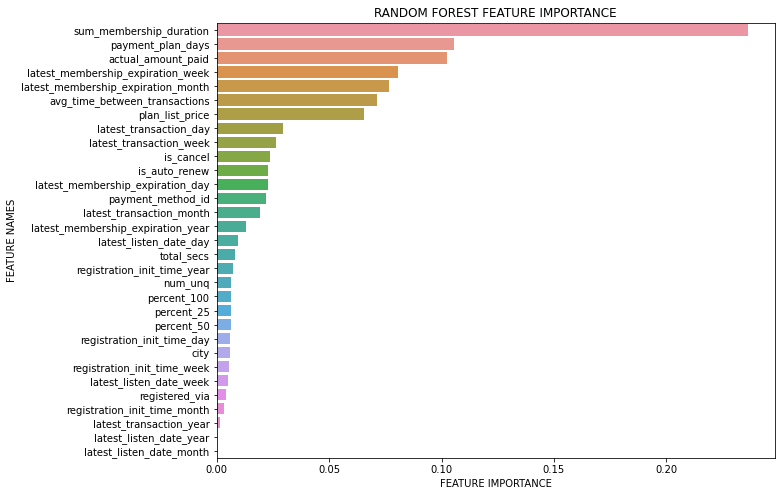

In [119]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
plot_feature_importance(tune_rfc.feature_importances_,X_train.columns, 'RANDOM FOREST')

# We can see that as expected, membership duration and payments are the top features in determining
# churn rate for the random forest.

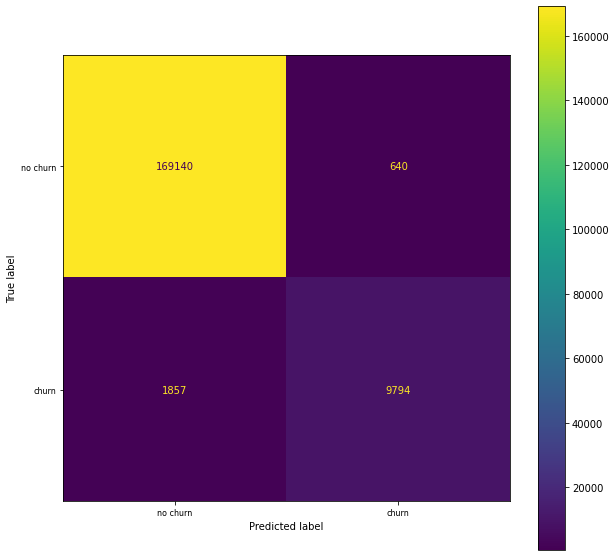

In [78]:
# Let's plot the confusion matrix.

cm = confusion_matrix(y_test, y_pred, labels = tune_rfc.classes_)
fig, ax = plt.subplots(figsize = (10,10))
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no churn', 'churn'],
                                   )
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no churn', 'churn'], fontsize = 8)
ax.set_yticklabels(labels = ['no churn', 'churn'], fontsize = 8)
display_cm.plot(ax = ax)

# Not bad! Our Random Forest has an F1 score of 89, and correctly predicts 9794 
# churned users.

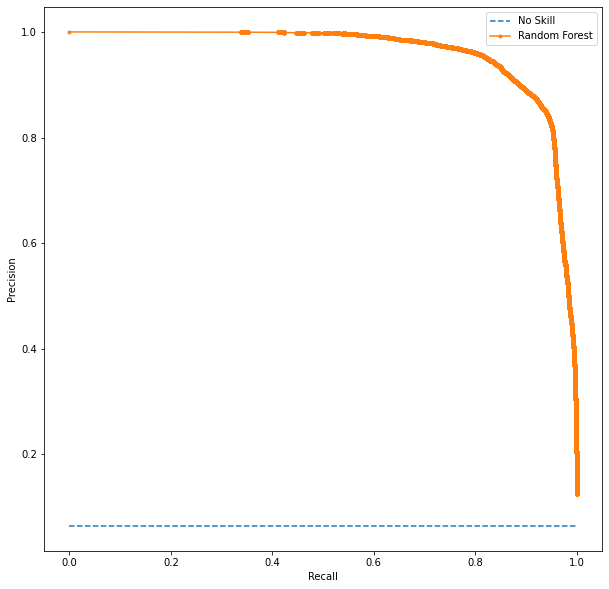

In [9]:
# Plotting the Precision-Recall curve for the Random Forest shows this is a
# good model in terms of performance.
model = RandomForestClassifier( n_estimators=100, random_state = 42, max_depth = 20, max_features = 'auto',
                             n_jobs=-1)
model = model.fit(X_train_scaled,y_train)
plt.figure(figsize=(10,10))
rf_probs = model.predict_proba(X_test_scaled)
rf_probs = rf_probs[:,1]
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(rf_recall, rf_precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [80]:
# Now let's try Logistic Regression.


lr = LogisticRegression(solver = 'liblinear', max_iter = 500)
model_res = lr.fit(X_train_scaled, y_train)

In [81]:
# Use Randomized Search cross validation to determine the best hyperparameters.

#C = [100,10,1.0,0.1,0.01]
#solver = ['newton-cg','lbfgx','liblinear']


#lr_pipe = Pipeline(
#steps = [('standardscaler', StandardScaler()),
#('classifier', LogisticRegression())])


#grid_params = {'standardscaler': [StandardScaler(),None],
#               'classifier__C' : C,
#               'classifier__solver': solver
#}

#lr_grid_cv = RandomizedSearchCV(lr_pipe, param_distributions = grid_params, cv = StratifiedKFold(5), n_jobs = -1, scoring = 'f1')
#model = lr_grid_cv.fit(X_train,y_train)
#model.best_params_

C:\Users\marsh\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.65832827 0.65832836 0.59064345 0.49693225 0.49805532
        nan 0.64731155 0.65845913 0.4962348 ]
  warnings.warn(


{'standardscaler': StandardScaler(),
 'classifier__solver': 'newton-cg',
 'classifier__C': 10}

In [298]:
# Fit the model with above hyperparameters.

tune_lr = LogisticRegression(solver = 'newton-cg', C = 10, random_state = 42,n_jobs=-1)

    
tune_lr = tune_lr.fit(X_train_scaled, y_train)
y_pred = tune_lr.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

y_pred_test = tune_lr.predict(X_test_scaled)
y_pred_train = tune_lr.predict(X_train_scaled)
print(classification_report(y_train, y_pred_train)), print(classification_report(y_test,y_pred_test))

# We show a huge dip in performance for the Logistic Regression model. A PR
# curve and confusion matrix reinforces this.

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    509339
           1       0.85      0.54      0.66     34952

    accuracy                           0.96    544291
   macro avg       0.91      0.77      0.82    544291
weighted avg       0.96      0.96      0.96    544291

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    169780
           1       0.84      0.53      0.65     11651

    accuracy                           0.96    181431
   macro avg       0.91      0.76      0.82    181431
weighted avg       0.96      0.96      0.96    181431



(None, None)

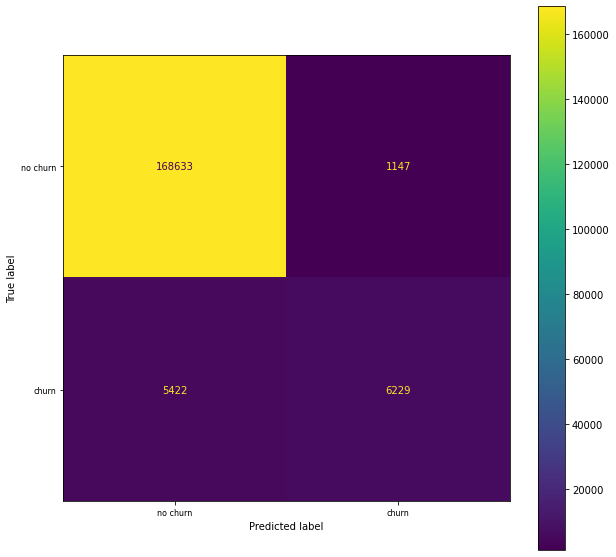

In [83]:
cm = confusion_matrix(y_test, y_pred_test, labels = tune_lr.classes_)
fig, ax = plt.subplots(figsize = (10,10))
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no churn', 'churn'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no churn', 'churn'], fontsize = 8)
ax.set_yticklabels(labels = ['no churn', 'churn'], fontsize = 8)
display_cm.plot(ax = ax)

# The model only correctly predicts 6229 churn users.

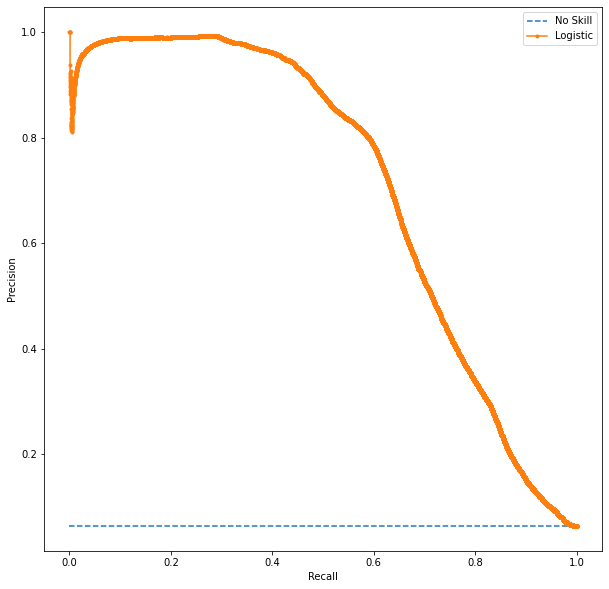

In [85]:
model = tune_lr.fit(X_train_scaled,y_train)
plt.figure(figsize=(10,10))
lr_probs = model.predict_proba(X_test_scaled)
lr_probs = lr_probs[:,1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [187]:
# Lastly, let's try an Extreme Gradient Boost.
xgb = XGBClassifier()
model = xgb.fit(X_train_scaled, y_train)

In [87]:
#max_depth = [6,10,20]
#n_estimators = [10,100,1000]
#min_child_weight = [1,5,100]
#max_depth,n_estimators

#xgb_pipe = Pipeline(
#steps = [('standardscaler', StandardScaler()),
#('classifier', XGBClassifier())])


#grid_params = {'standardscaler': [StandardScaler(),None],
#               'classifier__n_estimators' : n_estimators,
#               'classifier__max_depth': max_depth,
#               'classifier__min_child_weight': min_child_weight
#}

#xgb_grid_cv = RandomizedSearchCV(xgb_pipe, param_distributions = grid_params, cv = StratifiedKFold(5), n_jobs = -1, scoring = 'f1')
#model = xgb_grid_cv.fit(X_train,y_train)
#model.best_params_

{'standardscaler': None,
 'classifier__n_estimators': 100,
 'classifier__min_child_weight': 1,
 'classifier__max_depth': 20}

In [11]:
# After fitting the model with the above hyperparameters, we see that the XGB
# performs slightly better than the random forest.

tune_xgb = XGBClassifier(n_estimators = 100, min_child_weight = 1, max_depth = 20, 
                             random_state = 42)
scaler = StandardScaler()
scaler.fit(X_train, y_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
tune_xgb = tune_xgb.fit(X_train, y_train)

y_pred_test = tune_xgb.predict(X_test)
y_pred_train = tune_xgb.predict(X_train)
print(classification_report(y_train, y_pred_train)), print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    509339
           1       1.00      1.00      1.00     34952

    accuracy                           1.00    544291
   macro avg       1.00      1.00      1.00    544291
weighted avg       1.00      1.00      1.00    544291

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    169780
           1       0.91      0.88      0.90     11651

    accuracy                           0.99    181431
   macro avg       0.95      0.94      0.94    181431
weighted avg       0.99      0.99      0.99    181431



(None, None)

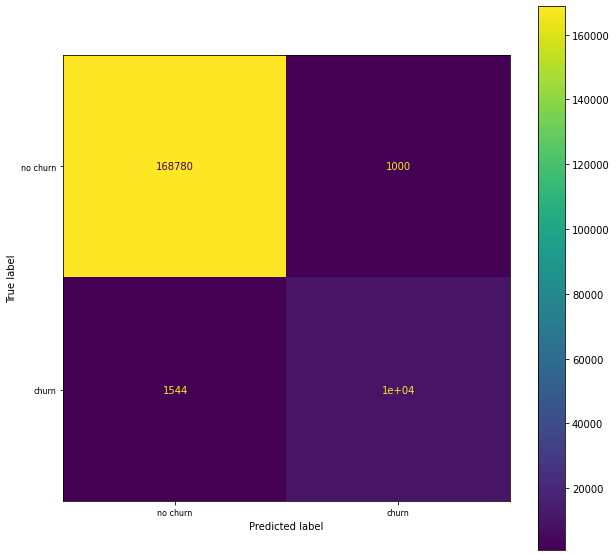

In [22]:
# Let's also plot the confusion matrix, PR curve, and ROC/AUC graphs for good measure.

cm = confusion_matrix(y_test, y_pred_test, labels = tune_xgb.classes_)
fig, ax = plt.subplots(figsize =(10,10))
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no churn', 'churn'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no churn', 'churn'], fontsize = 8)
ax.set_yticklabels(labels = ['no churn', 'churn'], fontsize = 8)
display_cm.plot(ax = ax)

In [23]:
cm

# We notice here that XGB still does slightly better in terms of true positive labels (10107) and
# minimal false negatives (1544).

array([[168780,   1000],
       [  1544,  10107]], dtype=int64)

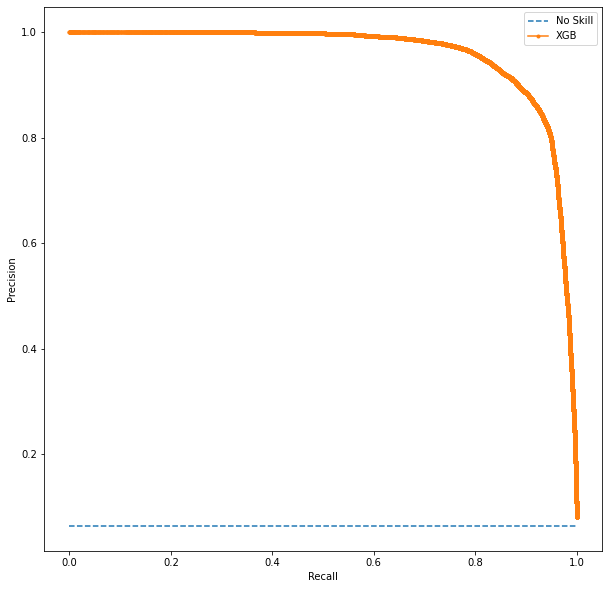

In [226]:
plt.figure(figsize=(10,10))
pred_proba = tune_model.predict_proba(X_test)[:,1]
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, pred_proba)
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(xgb_recall, xgb_precision, marker='.', label='XGB')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()


In [312]:
from sklearn.metrics import roc_curve, roc_auc_score,auc

rfc_pred = tune_rfc.predict_proba(X_test)[:,1]
lr_pred = tune_lr.predict_proba(X_test)[:,1]
xgb_pred = tune_xgb.predict_proba(X_test)[:,1]

rfcfpr,rfctpr,threshold1 = roc_curve(y_test, rfc_pred)
lrfpr, lrtpr, threshold2 = roc_curve(y_test,lr_pred)
xgbfpr,xgbtpr, threshold3 = roc_curve(y_test,xgb_pred)

print('roc_auc_score for Random forest: ', roc_auc_score(y_test, rfc_pred))
print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, lr_pred))
print('roc_auc_score for Extreme Gradient Boost: ', roc_auc_score(y_test, xgb_pred))

roc_auc_score for Random forest:  0.9957488895013039
roc_auc_score for Logistic Regression:  0.9056945333355563
roc_auc_score for Extreme Gradient Boost:  0.9961784489712937


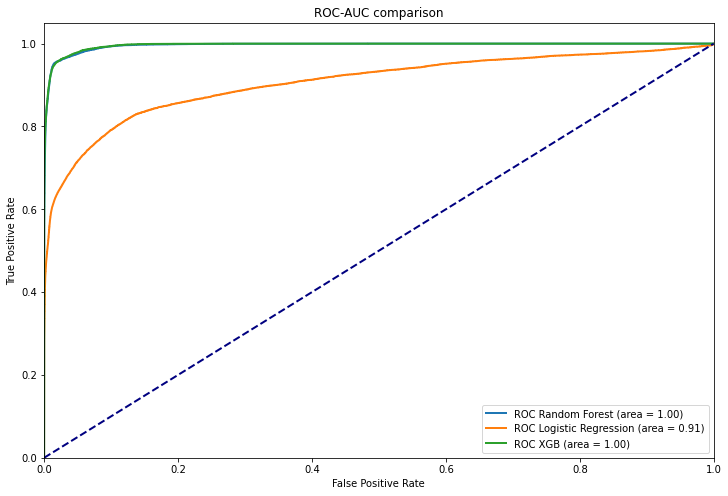

In [314]:
plt.figure(figsize= (12,8))

for fpr, tpr, model in [(rfcfpr,rfctpr, 'Random Forest'), (lrfpr, lrtpr, 'Logistic Regression'),
                       (xgbfpr,xgbtpr, 'XGB')]:
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr, lw=2, label='ROC '+ model + ' (area = %0.2f)' % roc_auc)
    

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC comparison')
plt.legend(loc="lower right")
plt.show()

# The below shows that XGB and Random Forest models perform about the same in terms of ROC score.

In [86]:
# Lets compare scores on the table.

scores = {'Model': ['Random Forest','Logistic Regression', 'XGB'], 'Precision': [0.94,0.84,0.91], 'Recall': [0.84,0.53,0.88], 'f1-score' : [0.89,0.65,0.90]}
scores = pd.DataFrame(scores)
scores

,Model,Precision,Recall,f1-score
0,Random Forest,0.94,0.84,0.89
1,Logistic Regression,0.84,0.53,0.65
2,XGB,0.91,0.88,0.90


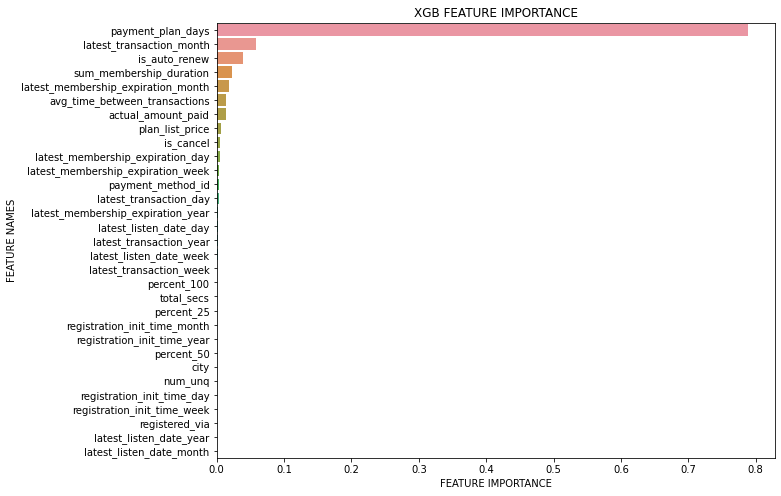

In [121]:
# Similar to the random forest, let's plot the feature importances for our XGB model.

plot_feature_importance(tune_xgb.feature_importances_,X_train.columns, 'XGB')

# We see here that it considers payment plan days as the most important feature by far when
# determining user churn. Total membership comes in at fourth , and actual amount paid is surprisingly
# low at seventh. Even though this is surprising, I'll still be going with XGB since it has a 
# higher recall score.

In [19]:
# Here, I'm determing the optimal threshold using F1.

def precision_recall(model, X_test, y_test, threshold, beta = 1.0):
    y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(bool)
    matrix = confusion_matrix(y_test, y_pred)
    
    tn = matrix[0,0]
    tp = matrix[1,1]
    fp = matrix[0,1]
    fn = matrix[1,0]
    
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    f_beta = fbeta_score(y_test, y_pred, beta=beta)
    
    return([precision, recall, f_beta])

In [22]:
y_pred = tune_xgb.predict(X_test)
print(classification_report(y_test,y_pred))
threshold_df = pd.DataFrame(columns=['Precision','Recall','F1'])

for threshold in np.arange(0.1,.9,.02):
    
    threshold_df.loc[threshold] = precision_recall(tune_xgb, X_test, y_test, threshold)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99    169780
           1       0.91      0.88      0.90     11651

    accuracy                           0.99    181431
   macro avg       0.95      0.94      0.94    181431
weighted avg       0.99      0.99      0.99    181431



In [23]:
threshold_df[threshold_df.F1 == threshold_df.F1.max()]

# The optimal threshold for our dataset is 0.36 vs the default.

,Precision,Recall,F1
0.34,0.890544,0.902927,0.896693


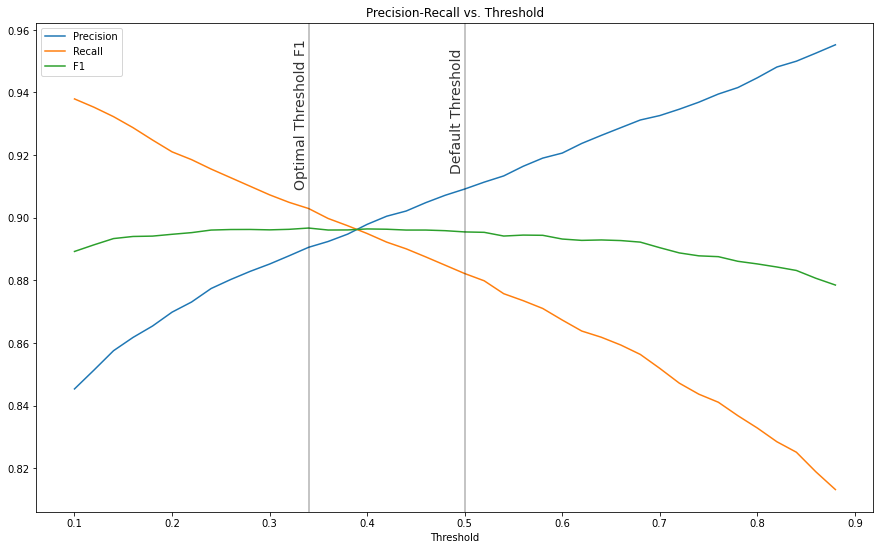

In [27]:
ax = threshold_df.plot(figsize=(15,9))
ax.set_xlabel('Threshold')
ax.set_title('Precision-Recall vs. Threshold')
ax.axvline(0.34, color='black', alpha=0.3)
ax.text(.325,.910,'Optimal Threshold F1',rotation=90, alpha=0.8, fontsize=14)
ax.axvline(0.5, color ='black', alpha = 0.3)
ax.text(.485,.915,'Default Threshold',rotation=90, alpha=0.8,fontsize=14);

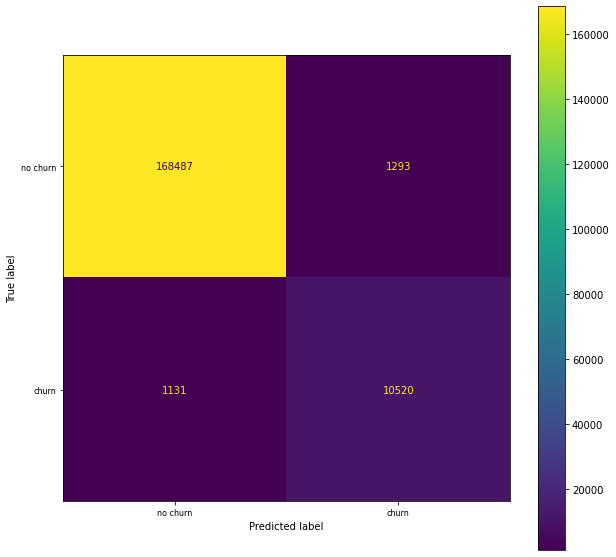

In [37]:
# New confusion matrix using the 0.34 threshold.

y_pred = (tune_xgb.predict_proba(X_test)[:,1] >= 0.34).astype(bool)

cm = confusion_matrix(y_test, y_pred, labels = tune_xgb.classes_)
fig, ax = plt.subplots(figsize =(10,10))
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no churn', 'churn'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no churn', 'churn'], fontsize = 8)
ax.set_yticklabels(labels = ['no churn', 'churn'], fontsize = 8)
display_cm.plot(ax = ax)


Conclusions: Since we are focusing on true positive rate, I decided to go with the Extreme Gradient Boosted model due to its higher F1 and recall scores. The feature importances line up with our preliminary analysis in that the top three features that affect user churn are auto renewal, payment plan days, total membership duration, and actual amount paid.